<a href="https://www.kaggle.com/code/mohammadelsayedfahmy/algorithm-for-landmark-classification-cnn?scriptVersionId=102622839" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
! pip install split-folders

In [2]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import torch
from torchvision import datasets, transforms
import numpy as np
import splitfolders

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# Create Transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    # Augmentation
    transforms.RandomHorizontalFlip(p=0.3), 
    transforms.RandomRotation(10),
    transforms.RandomChoice([
            transforms.ColorJitter(hue=0.1),
            transforms.ColorJitter(brightness=0.2),
            transforms.ColorJitter(saturation=0.2),
            transforms.ColorJitter(contrast=0.2),
        ]),
    transforms.ToTensor(),
    transforms.Normalize(mean, std) # Imagenet standards
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std) # Imagenet standards
])

# Split the training folder to new training and validation folders
splitfolders.ratio("../input/landmark-images/landmark_images/train", output="train_valid", seed=1337, ratio=(.8, .2), group_prefix=None)
# Load the image data
train_data = datasets.ImageFolder('./train_valid/train', transform=train_transform)
valid_data = datasets.ImageFolder('./train_valid/val', transform=test_transform)
test_data = datasets.ImageFolder('../input/landmark-images/landmark_images/test', transform=test_transform)
# Save classes names 
n_classes = len(train_data.classes)
classes = [class_.split(".")[1].replace("_", " ") for class_ in train_data.classes]
batch_size = 20
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)
loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

Copying files: 4996 files [00:19, 260.98 files/s]


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
- I randomly resized crop the images to 224x224 pixels for training and for testing, I did normal resized to 256, then center crop to 224x224 pixels size.then center crop to 224x224 pixels size. I have picked 224x224 pixels as the size of the input tensor.
- Data augmentation has been applied on just the training subset of the dataset through random rotations of 10 degrees and random horizontal flips to the images, also with random and different color jitters.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

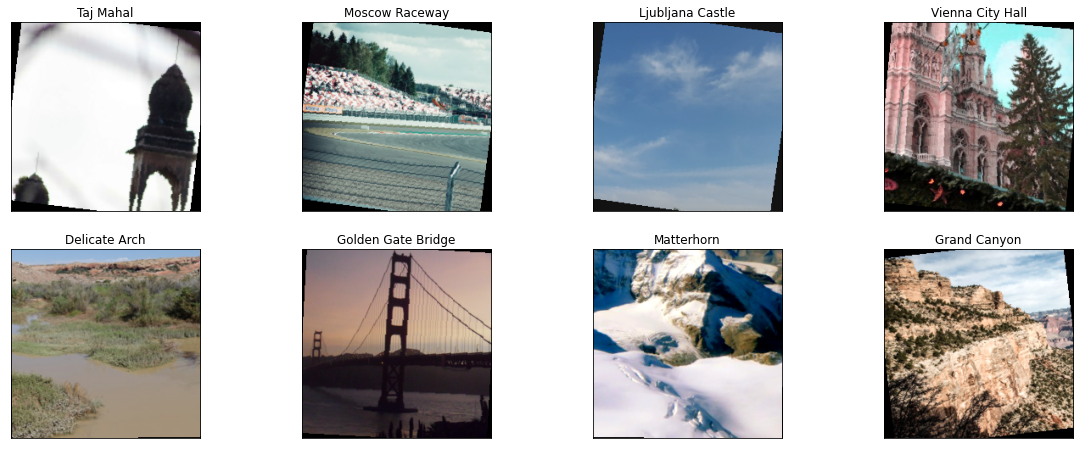

In [3]:
def unnormlize(img, s, m):
    return img * s[:, None, None] + m[:, None, None]

import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
import random
fig = plt.figure(figsize=(20,2*8))
for idx in range(8):
    ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[], )
    rand_img = random.randint(0, len(train_data))
    img = unnormlize(train_data[rand_img][0], torch.Tensor(std), torch.Tensor(mean)) # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0))) # convert from Tensor image
    class_name = classes[train_data[rand_img][1]]
    ax.set_title(class_name)

### Initialize use_cuda variable

In [4]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [5]:
## TODO: select loss function
import torch.nn as nn
import torch.optim as optim
criterion_scratch = nn.CrossEntropyLoss() 
def get_optimizer_scratch(model):    
    ## TODO: select and return an optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    return optimizer   

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [6]:
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)       
        self.pool = nn.MaxPool2d(2, 2)        
        self.fc1 = nn.Linear(28 * 28 * 64, 256)
        self.fc2 = nn.Linear(256, n_classes) # n_classes = 50       
        self.dropout = nn.Dropout(0.3)        
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)        
        self.batch_norm2d = nn.BatchNorm2d(32)
        self.batch_norm1d = nn.BatchNorm1d(256)            
    def forward(self, x):
        ## Define forward behavior
        # sequence of convolutional and max pooling layers
        x = self.pool(self.leaky_relu(self.conv1(x)))
        x = self.pool(self.leaky_relu(self.conv2(x)))
        x = self.batch_norm2d(x)
        x = self.pool(self.leaky_relu(self.conv3(x)))        
        x = x.view(-1, 28 * 28 * 64)        
        x = self.dropout(x)       
        x = self.leaky_relu(self.fc1(x))        
        x = self.batch_norm1d(x)       
        x = self.dropout(x)     
        x = self.fc2(x)        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  
- CNN contains of 3 layers as follows 
- 1-Conv1 - 224x224 16 | Leaky relu activation function
- 2-Conv2 - 112x112 32 | Leaky relu activation function
- 3-Conv3 - 56x56 64 | Leaky relu activation function
  and 2 fully connected layers and dropout of 30 % probability,
  Dropout of 30% probability,Dropout has been used to avoid overfitting and Max-pooling layers to focus on the main target    features via dividing the image by a factor of 2. I attempted to speed up the training process and to perform some regularization to the model via Batch Normalization.



### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [7]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

            
        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
            
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, 
                                                                                   train_loss,
                                                                                   valid_loss))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,
                                                                                            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [8]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, np.sqrt(2. / n))
        if m.bias is not None:
            m.bias.data.zero_()
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0, y)
        m.bias.data.zero_()
    
#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.926198 	Validation Loss: 3.393158
Validation loss decreased (inf --> 3.393158).  Saving model ...
Epoch: 2 	Training Loss: 3.649304 	Validation Loss: 3.266023
Validation loss decreased (3.393158 --> 3.266023).  Saving model ...
Epoch: 3 	Training Loss: 3.521613 	Validation Loss: 3.189282
Validation loss decreased (3.266023 --> 3.189282).  Saving model ...
Epoch: 4 	Training Loss: 3.412722 	Validation Loss: 3.181021
Validation loss decreased (3.189282 --> 3.181021).  Saving model ...
Epoch: 5 	Training Loss: 3.379200 	Validation Loss: 3.068270
Validation loss decreased (3.181021 --> 3.068270).  Saving model ...
Epoch: 6 	Training Loss: 3.336458 	Validation Loss: 3.034499
Validation loss decreased (3.068270 --> 3.034499).  Saving model ...
Epoch: 7 	Training Loss: 3.230567 	Validation Loss: 2.981049
Validation loss decreased (3.034499 --> 2.981049).  Saving model ...
Epoch: 8 	Training Loss: 3.183311 	Validation Loss: 2.877613
Validation loss decreased (2.98104

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [9]:
## TODO: you may change the number of epochs if you'd like,
num_epochs = 20 

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.679636 	Validation Loss: 3.384055
Validation loss decreased (inf --> 3.384055).  Saving model ...
Epoch: 2 	Training Loss: 3.464496 	Validation Loss: 3.213506
Validation loss decreased (3.384055 --> 3.213506).  Saving model ...
Epoch: 3 	Training Loss: 3.353839 	Validation Loss: 3.078757
Validation loss decreased (3.213506 --> 3.078757).  Saving model ...
Epoch: 4 	Training Loss: 3.279400 	Validation Loss: 3.070976
Validation loss decreased (3.078757 --> 3.070976).  Saving model ...
Epoch: 5 	Training Loss: 3.215212 	Validation Loss: 3.097412
Epoch: 6 	Training Loss: 3.160887 	Validation Loss: 2.891151
Validation loss decreased (3.070976 --> 2.891151).  Saving model ...
Epoch: 7 	Training Loss: 3.104093 	Validation Loss: 2.842312
Validation loss decreased (2.891151 --> 2.842312).  Saving model ...
Epoch: 8 	Training Loss: 3.049469 	Validation Loss: 2.812565
Validation loss decreased (2.842312 --> 2.812565).  Saving model ...
Epoch: 9 	Training Loss: 3.019490 

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [10]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.390192


Test Accuracy: 41% (517/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [11]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

#loaders_transfer = {'train': None, 'valid': None, 'test': None}

loaders_transfer = loaders_scratch.copy()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [12]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss() 
def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)
    # more general solution:
    # filter(lambda param: param.requires_grad, model_transfer.parameters())
    return optimizer

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [13]:
## TODO: Specify model architecture
from torchvision import models
model_transfer = models.vgg16(pretrained=True)
# Freeze training for all "features" layers
for parameter in model_transfer.features.parameters():
    parameter.requires_grad = False    
# replace the final layer with one of your own problem
n_input = model_transfer.classifier[6].in_features
model_transfer.classifier[6] = nn.Linear(n_input, n_classes) 
#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
- i choosed VGG-16 becase it is better than DenseNet-161 .this arch gives us a good architecture and taking all preceding feature-maps as input.and that gives me higher scores and faster performace so my accuracy 78% after 15 epoches

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [14]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
train(15, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), criterion_transfer,
      use_cuda, 'model_transfer.pt')
#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.618664 	Validation Loss: 1.497178
Validation loss decreased (inf --> 1.497178).  Saving model ...
Epoch: 2 	Training Loss: 1.715965 	Validation Loss: 1.285355
Validation loss decreased (1.497178 --> 1.285355).  Saving model ...
Epoch: 3 	Training Loss: 1.523343 	Validation Loss: 1.168366
Validation loss decreased (1.285355 --> 1.168366).  Saving model ...
Epoch: 4 	Training Loss: 1.403786 	Validation Loss: 1.138320
Validation loss decreased (1.168366 --> 1.138320).  Saving model ...
Epoch: 5 	Training Loss: 1.330451 	Validation Loss: 1.090675
Validation loss decreased (1.138320 --> 1.090675).  Saving model ...
Epoch: 6 	Training Loss: 1.263175 	Validation Loss: 1.077488
Validation loss decreased (1.090675 --> 1.077488).  Saving model ...
Epoch: 7 	Training Loss: 1.167143 	Validation Loss: 1.031618
Validation loss decreased (1.077488 --> 1.031618).  Saving model ...
Epoch: 8 	Training Loss: 1.125266 	Validation Loss: 1.021818
Validation loss decreased (1.03161

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [15]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.788190


Test Accuracy: 79% (990/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [16]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    img = Image.open(img_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    img = transform(img)
    img.unsqueeze_(0)
    
    if use_cuda:
        img = img.cuda()
        
    model_transfer.eval()
    output = model_transfer(img)
    top_values, top_idx = output.topk(k)

    top_classes = [classes[class_id] for class_id in top_idx[0].tolist()]
    return top_classes

# test on a sample image
predict_landmarks('../input/landmark-images/landmark_images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden Gate Bridge',
 'Forth Bridge',
 'Brooklyn Bridge',
 'Dead Sea',
 'Niagara Falls']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

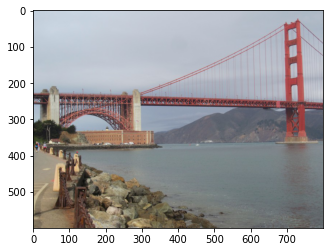

Actual Label: dmark-images
Predicted Label in order: Is this picture of the
 Golden Gate Bridge, Forth Bridge, or Brooklyn Bridge?


In [17]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    plt.show()

    print(f"Actual Label: {img_path.split('/')[2][3:].replace('_',' ').split('.')[0]}")
    print(f"Predicted Label in order: Is this picture of the\n {predicted_landmarks[0]}, {predicted_landmarks[1]}, or {predicted_landmarks[2]}?")
    

# test on a sample image
suggest_locations('../input/landmark-images/landmark_images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
- The outputs are pretty good
- Possible points for improvement:
    1- Providing more images to train
    2- Doing more data augmentations techniques
    3- Maybe Trying other transfer learning models

In [18]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
import os

for img_path in os.listdir('../input/landmark-images/landmark_images/test'):
    img_path = os.path.join('../input/landmark-images/landmark_images/test', img_path)
    if img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif','jfif')):
        suggest_locations(img_path)